# Adjacency Matrix as Distance Matrix

In [321]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [378]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
import umap.plot
import scipy

import igraph as ig

sns.set()

# Exploring UMAP on a complete graph  (aka. 1-skeleton of an n-simplex)

Starting with a simple extreme case to see what's going on. How does the $X \rightarrow U(X)$ step work when all points are equidistant to each other? 

**Starter question:** When everything is equally far apart, how does it pick $k$ neighbours when $n$ is bigger than $k$? I'm thinking about whether it breaks it down in a balanced way or not. How does it tear apart something it can't? What happens? An $n$-simplex lives in $n-1$ dimensions. Does it do what's expected when $k=n-1$? How do parameter choices impact this?

In [323]:
k = 10
n = 20

Adjacency matrix $M$ of a complete graph $X$

In [324]:
M = np.ones((n, n)) - np.identity(n)

Get the adjacency matrix $A$ of $U(X)$

In [325]:
random_state = 42
metric = 'precomputed'

In [326]:
def get_graph_UX(X,
                 n_neighbors,
                 random_state,
                 metric,
                 local_connectivity=1.0):
    """
    A subset of the paramters from umap.umap_.fuzzy_simplicial_set. Note that this will set `apply_set_operations` to False.

    Returns
    --------
    The weighted UMAP graph U(X) as an igraph object with sigmas and rhos as vertex attributes
    """
    A, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X, 
                                                             n_neighbors=n_neighbors, 
                                                             random_state=random_state, 
                                                             metric=metric, 
                                                             local_connectivity=local_connectivity,
                                                             return_dists=True,
                                                             apply_set_operations=False)
    G = ig.Graph.Weighted_Adjacency(A, 'directed')
    G.vs['sigmas'] = sigmas
    G.vs['rhos'] = rhos
    return G

def get_VX_from_UX(UX, set_op_mix_ratio=1.0):
    """
    From the matrix of U(X), get the igraph of V(X). 
    
    set_op_mix_ratio is the same as the parameter of umap.umap_.fuzzy_simplicial_set. That is:
    
    set_op_mix_ratio: float (optional, default 1.0)
        Interpolate between (fuzzy) union and intersection as the set operation
        used to combine local fuzzy simplicial sets to obtain a global fuzzy
        simplicial sets. Both fuzzy set operations use the product t-norm.
        The value of this parameter should be between 0.0 and 1.0; a value of
        1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy
        intersection.
    """
    result = UX
    transpose = result.transpose()

    prod_matrix = result.multiply(transpose)

    result = (
        set_op_mix_ratio * (result + transpose - prod_matrix)
        + (1.0 - set_op_mix_ratio) * prod_matrix
    )
    G = ig.Graph.Weighted_Adjacency(result, 'undirected')
    return G

In [327]:
G = get_graph_UX(M,
                 n_neighbors=k,
                 random_state=random_state,
                 metric=metric)

Take a look at the matrix:

In [328]:
print(G.get_adjacency())

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0]
 [0, 0, 

In [329]:
np.unique(G.degree(), return_counts=True)

(array([ 9, 18, 28]), array([10,  1,  9]))

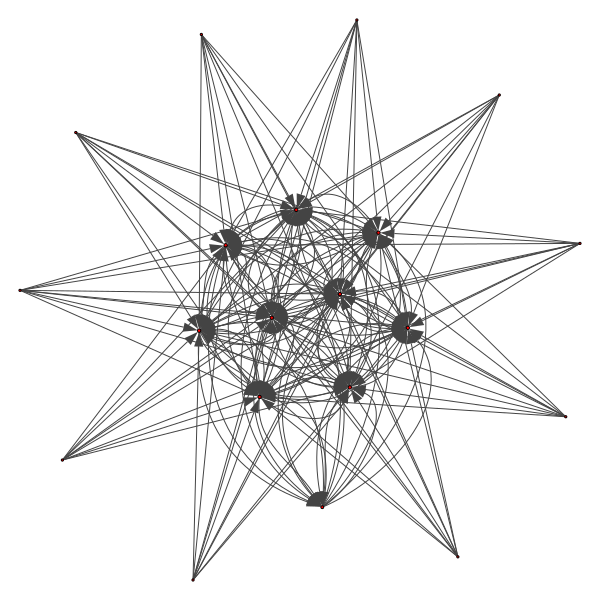

In [330]:
ig.plot(G, vertex_size=np.log(G.vs.degree()))

Decidedly not balanced. The tie break doesn't seem to be randomized. Let's see what happens downstream.

First, what happens when we symmetrize with fuzzy union?

Degrees: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 19, 19, 19, 19, 19, 19, 19, 19, 19, 9]


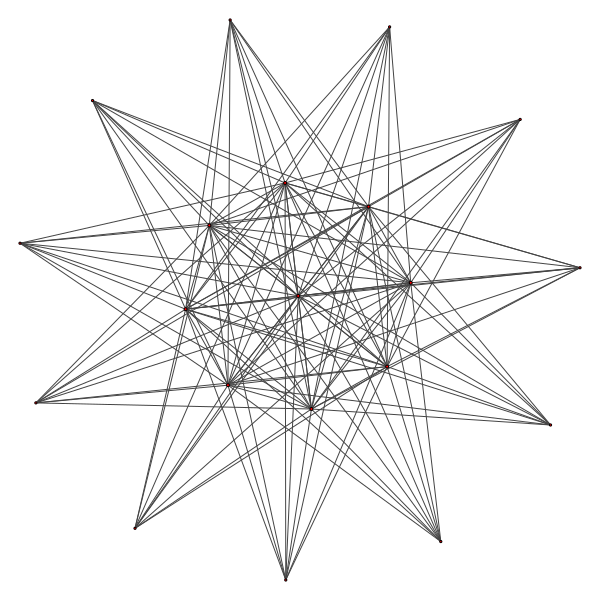

In [339]:
set_op_mix_ratio = 1.0
H = get_VX_from_UX(G.get_adjacency_sparse(), set_op_mix_ratio)
print(f'Degrees: {H.degree()}')
ig.plot(H, vertex_size=np.log(H.vs.degree()))

And now fuzzy intersection

Degrees: [0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0]


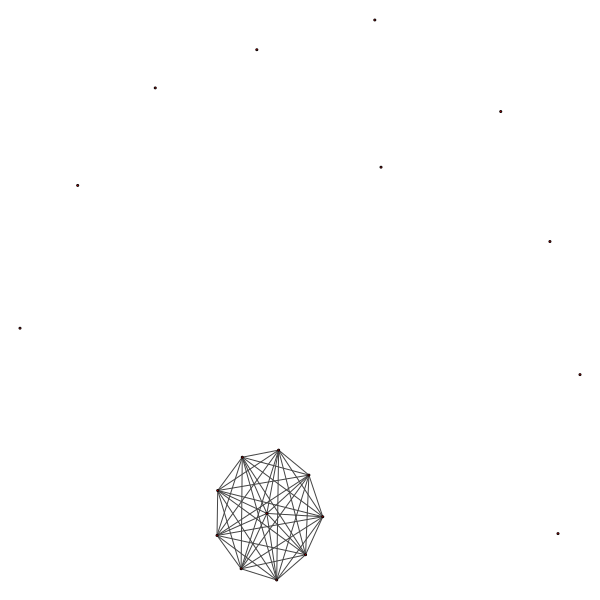

In [342]:
set_op_mix_ratio = 0.0
H = get_VX_from_UX(G.get_adjacency_sparse(), set_op_mix_ratio)
print(f'Degrees: {H.degree()}')
ig.plot(H, vertex_size=2)

In both cases it seems to preserve a single $k$-complete subgraph, and depending on whether it's a union or a intersection, connects or disconnects that subgraph to the other nodes. 



This persists with pretty much any value of $n$ you want to pick. Let's take a look at a larger value of $n$ to check.

In [343]:
n = 20000

In [344]:
M = np.ones((n, n)) - np.identity(n)

In [345]:
G = get_graph_UX(M,
                 n_neighbors=k,
                 random_state=random_state,
                 metric=metric)

In [346]:
np.unique(G.degree(), return_counts=True)

(array([    9,   159,   193,   419,   699,   785,  2965,  3481,  8960,
        10189, 16336, 16439, 19488, 20008]),
 array([19983,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     5]))

Sanity check: Row sums turn out as expected. Each node has $k-1$ outgoing edges.

In [347]:
np.unique(G.outdegree(), return_counts=True)

(array([9]), array([20000]))

Column sums are decidedly unbalanced. There are a few preferencial nodes with extremely high in-degree.

In [348]:
np.unique(G.indegree(), return_counts=True)

(array([    0,   150,   184,   410,   690,   776,  2956,  3472,  8951,
        10180, 16327, 16430, 19479, 19999]),
 array([19983,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     5]))

Let's explore the downstream effects for a moment. 

In [354]:
set_op_mix_ratio = 1.0
H = get_VX_from_UX(G.get_adjacency_sparse(), set_op_mix_ratio)
np.unique(H.degree(), return_counts=True)

(array([    9,   159,   193,   419,   699,   784,  2965,  3473,  8960,
        10180, 16327, 16430, 19479, 19999]),
 array([19983,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     5]))

In [357]:
set_op_mix_ratio = 0.0
H = get_VX_from_UX(G.get_adjacency_sparse(), set_op_mix_ratio)
np.unique(H.degree(), return_counts=True)

(array([0, 1, 8, 9]), array([19989,     1,     1,     9]))

Here's the non-zero degree subgraph, it's an almost $k-1$-complete graph.

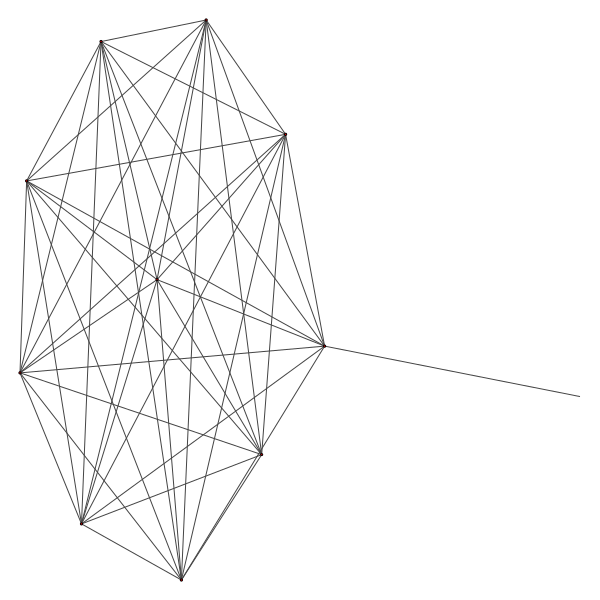

In [368]:
sg = H.subgraph([v for v in H.vs if (v.degree() > 0)])
ig.plot(sg, vertex_size=np.log(sg.vs.degree()))

Assuming fuzzy union, here's the 2D embedding we get:

<AxesSubplot:>

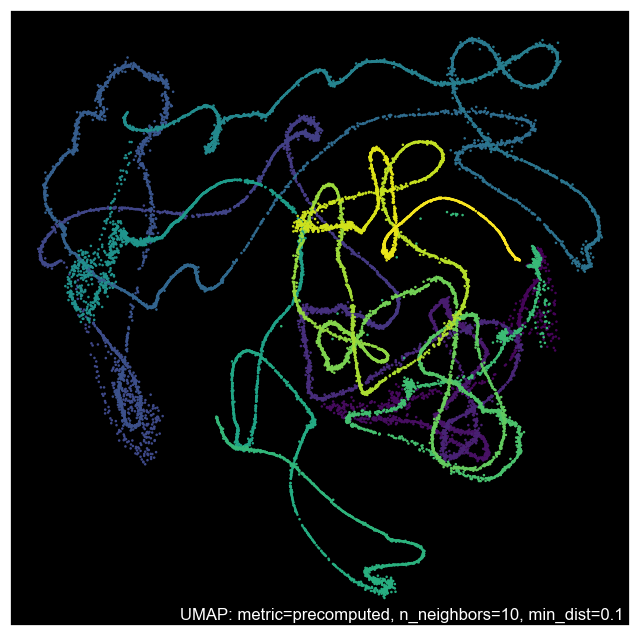

In [370]:
X_rep = umap.UMAP(n_neighbors=k,
                  random_state=random_state,
                  metric=metric).fit(M)
umap.plot.points(X_rep, values=np.arange(n), theme='viridis')

And assuming fuzzy intersection...

XXX Tried to compute this but it seems not to like a lot of zero degree nodes?!

## Add some noise

It seems unfair to expect UMAP to have a non-deterministic tie-break algorithm since it was written to deal with metric spaces (like Euclidean) where you don't expect to have a lot of pure (and equal) distances amongst neighbours. Let's add some noise to the distance matrix and see if it gives a balanced result then. 

In [373]:
n = 20

In [398]:
M = np.ones((n, n)) - np.identity(n) + ((np.random.rand(n,n)*0.1)-0.05)

In [399]:
G = get_graph_UX(M,
                 n_neighbors=k,
                 random_state=random_state,
                 metric=metric)

Good news: this seems to balance out the in-degrees a little bit better

In [401]:
np.unique(G.indegree(), return_counts=True)

(array([ 5,  7,  8,  9, 10, 11, 12, 15]), array([2, 3, 4, 3, 4, 1, 2, 1]))

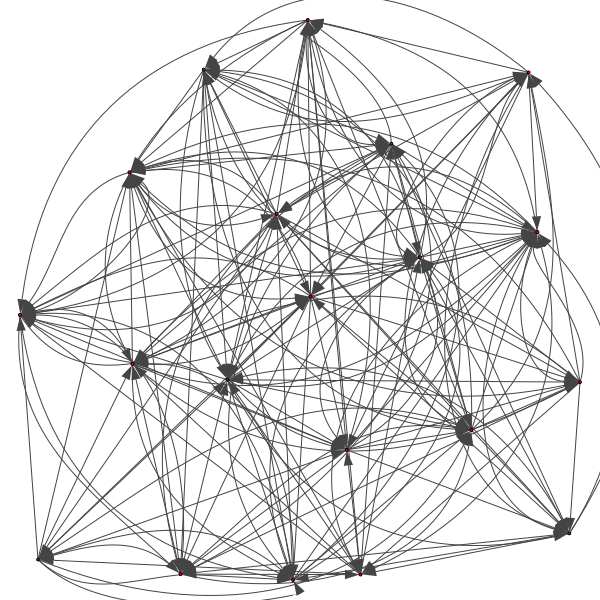

In [402]:
ig.plot(G, vertex_size=np.log(G.vs.degree()))

Fuzzy union and fuzzy intersection give the following graphs. 

Degrees: [13, 12, 13, 15, 15, 13, 13, 14, 14, 11, 16, 13, 13, 14, 15, 14, 15, 17, 16, 14]


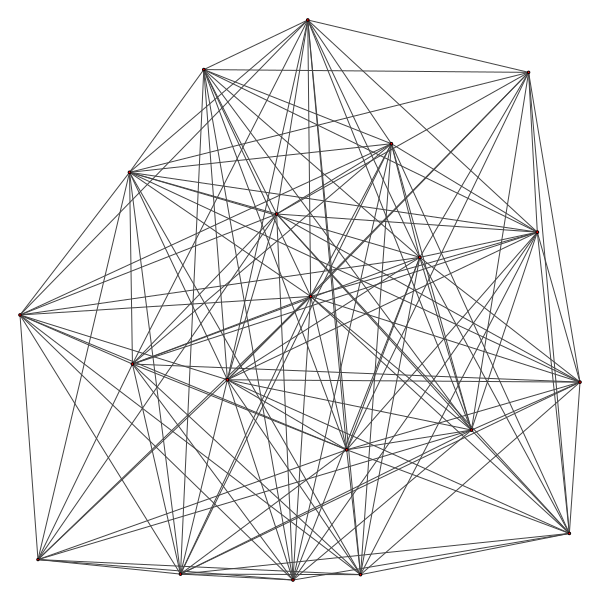

In [410]:
set_op_mix_ratio = 1.0
H = get_VX_from_UX(G.get_adjacency_sparse(), set_op_mix_ratio)
print(f'Degrees: {H.degree()}')
ig.plot(H, vertex_size=np.log(H.vs.degree()))

Degrees: [3, 4, 3, 6, 4, 5, 1, 3, 4, 3, 2, 7, 4, 5, 2, 3, 6, 2, 8, 5]


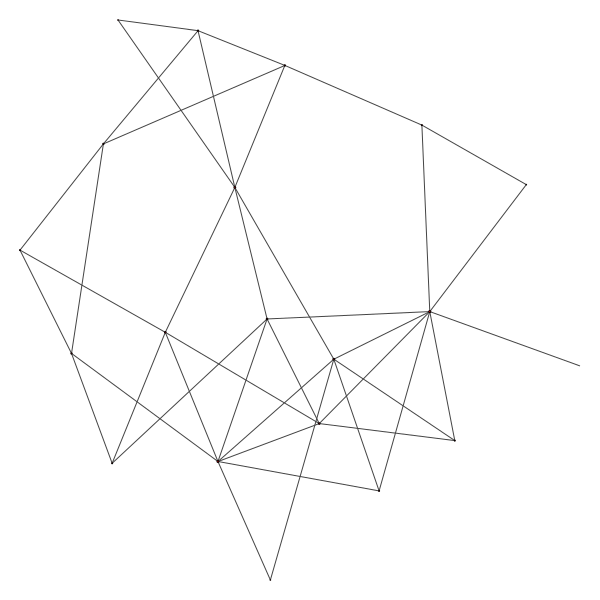

In [411]:
set_op_mix_ratio = 0.0
H = get_VX_from_UX(G.get_adjacency_sparse(), set_op_mix_ratio)
print(f'Degrees: {H.degree()}')
ig.plot(H, vertex_size=np.log(H.vs.degree()))

Let's look at the bigger example again, but with noise

In [414]:
n = 20000

In [415]:
M = np.ones((n, n)) - np.identity(n) + ((np.random.rand(n,n)*0.1)-0.05)

In [416]:
G = get_graph_UX(M,
                 n_neighbors=k,
                 random_state=random_state,
                 metric=metric)

Sanity check: Row sums turn out as expected. Each node has $k-1$ outgoing edges.

In [418]:
np.unique(G.outdegree(), return_counts=True)

(array([9]), array([20000]))

Column sums are now more balanced around $k$.

In [419]:
np.unique(G.indegree(), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 array([   2,   28,  113,  289,  679, 1199, 1810, 2392, 2626, 2560, 2347,
        2018, 1465, 1000,  656,  377,  208,  131,   57,   21,   16,    3,
           3]))

Let's explore the downstream effects for a moment. 

In [423]:
set_op_mix_ratio = 1.0
H = get_VX_from_UX(G.get_adjacency_sparse(), set_op_mix_ratio)
np.unique(H.degree(), return_counts=True)

(array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31]),
 array([   2,   28,  113,  291,  678, 1205, 1812, 2390, 2626, 2566, 2340,
        2023, 1461,  999,  654,  374,  208,  130,   57,   21,   16,    3,
           3]))

In [425]:
set_op_mix_ratio = 0.0
H = get_VX_from_UX(G.get_adjacency_sparse(), set_op_mix_ratio)
np.unique(H.degree(), return_counts=True)

(array([0, 1]), array([19918,    82]))

Here's the non-zero degree subgraph.

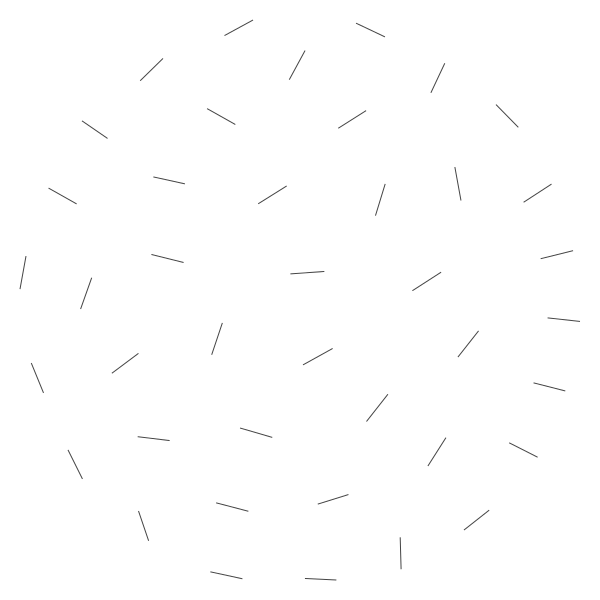

In [426]:
sg = H.subgraph([v for v in H.vs if (v.degree() > 0)])
ig.plot(sg, vertex_size=np.log(sg.vs.degree()))

Assuming fuzzy union, here's the 2D embedding we get:

<AxesSubplot:>

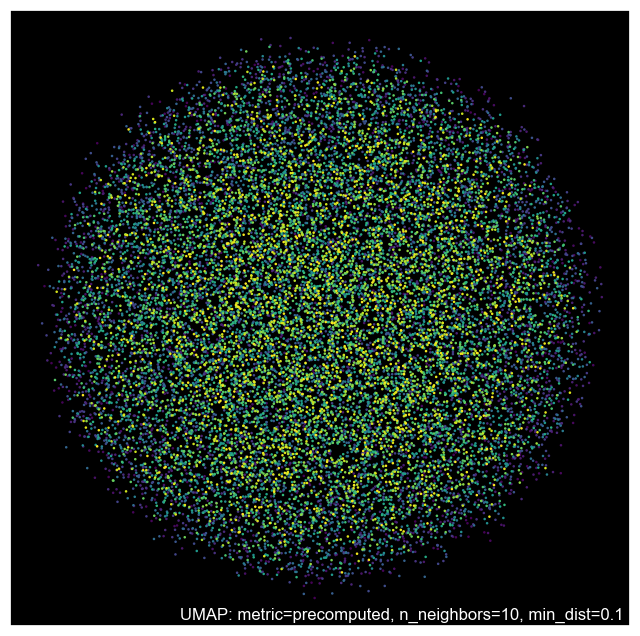

In [427]:
X_rep = umap.UMAP(n_neighbors=k,
                  random_state=random_state,
                  metric=metric).fit(M)
umap.plot.points(X_rep, values=np.arange(n), theme='viridis')

And assuming fuzzy intersection...

XXX again seems to handle lots of zero degree nodes poorly.

This suggests that when messing around with UMAP with objects with integral distances or lots of ties to break when making neighbour sets (e.g. graph distances coming from path lengths), then results will not be as expected and it can be "fixed" with a little bit of noise.